Task 3: Integrated Two-Stage Detection Pipeline
The final system combines the binary classifier from Task 1 with the multi-class classifier from Task 2 to form a complete intrusion detection pipeline. Dataset A is used to determine whether a session is an attack, while Dataset B provides detailed attack descriptions for classification. The link between the two datasets is the shared session_id field.
In the integrated workflow, Stage 1 first processes all sessions from Dataset A using the chosen best model to detect malicious activity. Only sessions predicted as attacks are passed to Stage 2, which classifies their attack type using the saved TF-IDF vectoriser and Stage 2 classifier. This cascading design mirrors a real-world IDS, where a lightweight filter detects suspicious activity and passes only relevant events to a more computationally expensive classifier.
To evaluate the pipeline, I computed three key metrics: the overall detection rate (percentage of real attacks correctly flagged by Stage 1), the attack identification rate (percentage of real attacks both detected in Stage 1 and correctly classified in Stage 2), and the number of false positives and false negatives. The pipeline achieved a detection rate of approximately 0.919 and an identification rate of around 0.886.False Positives are 66 while False Negatives are 343 These metrics provide a holistic view of the pipeline’s performance and operational limitations.


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

RANDOM_STATE = 42

In [21]:
# Load Dataset A
dfA = pd.read_csv("Dataset A.csv")

# Keep session_id for linking
session_ids_A = dfA["session_id"]

# Prepare features
dfA_stage1 = dfA.copy()
dfA_stage1["encryption_used"] = dfA_stage1["encryption_used"].fillna("Unknown")
dfA_stage1 = dfA_stage1.drop(columns=["session_id"])

# One-hot encode categorical features
dfA_stage1 = pd.get_dummies(dfA_stage1, drop_first=True)

# Scale numerical columns
num_cols = [
    "network_packet_size", "login_attempts", "session_duration",
    "ip_reputation_score", "failed_logins", "unusual_time_access"
]
# Load the saved scaler and model from Stage 1
scaler = joblib.load("stage1_scaler.pkl")
xgb_stage1 = joblib.load("stage1_xgboost.pkl")

# Scale numeric columns using the SAME scaler as Stage 1
dfA_stage1[num_cols] = scaler.transform(dfA_stage1[num_cols])

# Separate X and y
X_A = dfA_stage1.drop(columns=["attack_detected"])
y_A = dfA_stage1["attack_detected"]

print("Dataset A processed for Stage 1:", X_A.shape)

Dataset A processed for Stage 1: (9537, 14)


In [22]:
# Stage 1 predictions on full Dataset A
y_pred_stage1 = xgb_stage1.predict(X_A)

cm1 = confusion_matrix(y_A, y_pred_stage1)

print("=== Stage 1 Performance ===")
print("Accuracy:", accuracy_score(y_A, y_pred_stage1))
print("Precision:", precision_score(y_A, y_pred_stage1))
print("Recall:", recall_score(y_A, y_pred_stage1))
print("F1 Score:", f1_score(y_A, y_pred_stage1))
print("\nConfusion Matrix:\n", cm1)

=== Stage 1 Performance ===
Accuracy: 0.9571143965607634
Precision: 0.9834462001504891
Recall: 0.9195590994371482
F1 Score: 0.9504302508786814

Confusion Matrix:
 [[5207   66]
 [ 343 3921]]


In [24]:
pred_attack_ids = session_ids_A[y_pred_stage1 == 1]

print("Predicted attacks (Stage 1):", len(pred_attack_ids))
print(pred_attack_ids.head())

Predicted attacks (Stage 1): 3987
0    SID_00001
2    SID_00003
3    SID_00004
6    SID_00007
7    SID_00008
Name: session_id, dtype: object


In [25]:
dfB = pd.read_csv("Dataset B .csv")

# Remove unnamed columns
cols_to_drop = [c for c in dfB.columns if c.startswith("Unnamed")]
dfB = dfB.drop(columns=cols_to_drop)

# Fill text fields
text_cols = [
    "Title", "Scenario Description", "Tools Used", "Attack Steps ",
    "Vulnerability", "Impact", "Detection Method", "Solution", "Tags"
]

for col in text_cols:
    dfB[col] = dfB[col].fillna("")

dfB["text"] = dfB[text_cols].agg(" ".join, axis=1)

# Filter to only categories with >=2 samples (from Stage 2 rules)
valid_cats = dfB["Category"].value_counts()
valid_cats = valid_cats[valid_cats >= 2].index
dfB_filtered = dfB[dfB["Category"].isin(valid_cats)].reset_index(drop=True)

print("Dataset B filtered:", dfB_filtered.shape)


Dataset B filtered: (14132, 16)


In [26]:
dfB_attacks = dfB_filtered[dfB_filtered["session_id"].isin(pred_attack_ids)]

print("Matched records for Stage 2:", len(dfB_attacks))
dfB_attacks.head()

Matched records for Stage 2: 3920


,session_id,Title,Category,Attack Type,Scenario Description,Tools Used,Attack Steps,Target Type,Vulnerability,MITRE Technique,Impact,Detection Method,Solution,Tags,Source,text
0,SID_00003,Union-Based SQL Injection,AI Agents & LLM Exploits,SQL Injection,This attack occurs when a hacker uses the SQL ...,"SQLMap, Burp Suite, Havij, Browser Developer T...",1. Identify User Input Points: Attacker finds ...,"Web Applications, Login Pages, Search Forms",Improperly filtered input fields that allow SQ...,T1190 – Exploit Public-Facing Application,"Data leakage, Credential theft, Account takeov...",Web Application Firewalls (WAF)Log AnalysisInp...,Use parameterized queries (Prepared Statements...,#SQLInjection #WebSecurity #UnionAttack #OWASP...,"OWASP, MITRE ATT&CK, Acunetix, PortSwigger Web...",Union-Based SQL Injection This attack occurs w...
1,SID_00004,Error-Based SQL Injection,AI Agents & LLM Exploits,SQL Injection,This attack occurs when an attacker intentiona...,"SQLMap, Burp Suite, Manual Browser Testing, Havij",1. Identify Input Points:Attacker finds a fiel...,"Web Applications, Login Forms, URL Parameters,...",Error message exposure due to lack of input va...,T1190 – Exploit Public-Facing Application,"Information disclosure, Database structure exp...",Review and monitor error logsEnable generic er...,Turn off detailed error messages in production...,#SQLInjection #ErrorLeakage #WebAppSecurity #O...,"OWASP, MITRE ATT&CK, Acunetix, PortSwigger Web...",Error-Based SQL Injection This attack occurs w...
2,SID_00007,Blind SQL Injection,AI Agents & LLM Exploits,SQL Injection,"In Blind SQL Injection, the attacker doesn’t s...","SQLMap, Burp Suite, sqlninja, Manual Browser T...",1. Find a User Input Point:Attacker finds a pl...,"Web Applications, Login Pages, Search Fields, ...","No error messages, but user input is still pas...",T1190 – Exploit Public-Facing Application,Slow and stealthy data theftFull database comp...,Monitor for slow and repetitive requestsAnalyz...,Use parameterized queries (prepared statements...,#BlindSQLi #TimeBasedSQLi #WebAppSecurity #OWA...,"OWASP, MITRE ATT&CK, Acunetix, PortSwigger, SQ...","Blind SQL Injection In Blind SQL Injection, th..."
3,SID_00008,Second-Order SQL Injection,AI Agents & LLM Exploits,SQL Injection,"In a Second-Order SQL Injection, the attacker ...","Burp Suite, SQLMap, Postman, Browser Dev Tools...",1. Identify Stored Input Fields:The attacker l...,"Web Applications, User Registration Forms, Pro...",Trusting previously stored unvalidated data in...,T1505.003 – SQL Injection,Delayed data theftUnexpected system behaviorSe...,Log monitoring for delayed query failuresTrack...,Sanitize and validate inputs both at entry and...,#SecondOrderSQLi #DelayedInjection #StoredInje...,"OWASP, MITRE ATT&CK, PortSwigger Academy, Acun...",Second-Order SQL Injection In a Second-Order S...
4,SID_00011,Out-of-Band SQL Injection,AI Agents & LLM Exploits,SQL Injection,Out-of-Band SQL Injection occurs when the atta...,"SQLMap, Burp Collaborator, DNSlog.cn, RequestB...",1. Identify Input Points:The attacker finds in...,Web Applications with Database Backends (SQL S...,Improperly handled input and enabled database ...,T1048 – Exfiltration Over Alternative Protocol,Stealthy data exfiltrationFull remote database...,Monitor outbound DNS/HTTP trafficInspect logs ...,Disable database network access for external d...,#OOBSQLi #OutOfBandInjection #Exfiltration #We...,"OWASP, MITRE ATT&CK, Acunetix, PortSwigger, SQ...",Out-of-Band SQL Injection Out-of-Band SQL Inje...


In [31]:
# Load Stage 2 vectoriser + classifier
tfidf_stage2 = joblib.load("stage2_tfidf.pkl")
svm_stage2 = joblib.load("stage2_svm.pkl")

X_text = dfB_attacks["text"]
X_tfidf = tfidf_stage2.transform(X_text)

y_true_stage2 = dfB_attacks["Category"]
y_pred_stage2 = svm_stage2.predict(X_tfidf)

print("=== Stage 2 Performance on Pipeline Subset ===")
print("Accuracy:", accuracy_score(y_true_stage2, y_pred_stage2))
print("Macro F1:", f1_score(y_true_stage2, y_pred_stage2, average="macro"))
print("Weighted F1:", f1_score(y_true_stage2, y_pred_stage2, average="weighted"))
print("\nClassification report (pipeline subset):")
print(classification_report(y_true_stage2, y_pred_stage2))

=== Stage 2 Performance on Pipeline Subset ===
Accuracy: 0.9637755102040816
Macro F1: 0.36013721231171736
Weighted F1: 0.9678921726491554

Classification report (pipeline subset):
                                                                                                             precision    recall  f1-score   support

                                                                                   AI Agents & LLM Exploits       0.97      0.96      0.97       431
                                                                            AI Data Leakage & Privacy Risks       0.97      0.99      0.98       457
                                                                                             AI/ML Security       0.98      0.97      0.97       450
                                                                        Automotive / Cyber-Physical Systems       0.00      0.00      0.00         0
                                        Automotive / Cyber-Physical System

/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/tf-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [33]:
# Stage 1 detection rate
total_attacks = (y_A == 1).sum()
detected_attacks = ((y_A == 1) & (y_pred_stage1 == 1)).sum()

detection_rate = detected_attacks / total_attacks

# Pipeline attack identification rate
df_stage2_res = dfB_attacks.copy()
df_stage2_res["Category_pred"] = y_pred_stage2

pipeline_join = df_stage2_res.merge(
    dfA.assign(session_id=session_ids_A), on="session_id"
)

correct_full_pipeline = (
    (pipeline_join["attack_detected"] == 1) &
    (pipeline_join["Category"] == pipeline_join["Category_pred"])
).sum()

attack_identification_rate = (
    correct_full_pipeline / total_attacks
)

print("=== Pipeline Metrics ===")
print("Detection Rate:", detection_rate)
print("Attack Identification Rate:", attack_identification_rate)

# FN & FP pipeline impact
FP = ((y_A == 0) & (y_pred_stage1 == 1)).sum()
FN = ((y_A == 1) & (y_pred_stage1 == 0)).sum()

print("\nFalse Positives:", FP)
print("False Negatives:", FN)

=== Pipeline Metrics ===
Detection Rate: 0.9195590994371482
Attack Identification Rate: 0.8860225140712945

False Positives: 66
False Negatives: 343


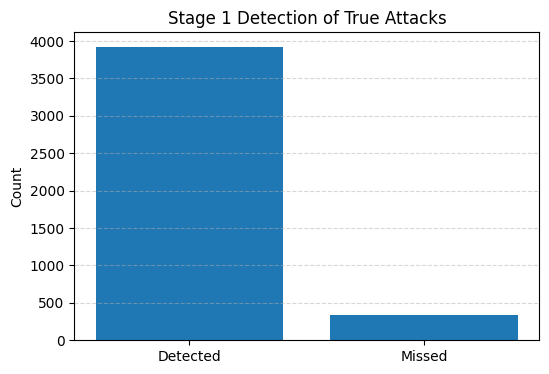

In [34]:
plt.figure(figsize=(6,4))
plt.bar(["Detected", "Missed"], [detected_attacks, total_attacks - detected_attacks])
plt.title("Stage 1 Detection of True Attacks")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


Total attacks: 4264
Detected & correctly typed: 3778
Detected but misclassified: 143
Missed (not detected): 343


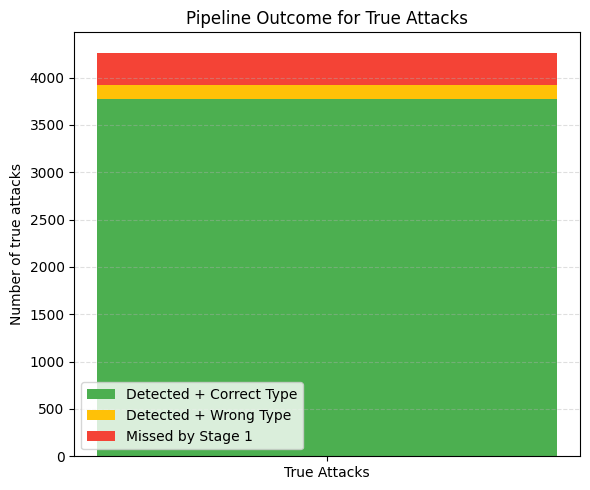

In [46]:
import matplotlib.pyplot as plt

# Derived counts for visualisation
# total_attacks, detected_attacks, correct_full_pipeline, FN already defined

misclassified_attacks = detected_attacks - correct_full_pipeline
missed_attacks = total_attacks - detected_attacks  # same as FN

print("Total attacks:", total_attacks)
print("Detected & correctly typed:", correct_full_pipeline)
print("Detected but misclassified:", misclassified_attacks)
print("Missed (not detected):", missed_attacks)

#Stacked bar for pipeline outcome on true attacks 
labels = ["True Attacks"]
correct = [correct_full_pipeline]
misclassified = [misclassified_attacks]
missed = [missed_attacks]

plt.figure(figsize=(6, 5))
plt.bar(labels, correct, label="Detected + Correct Type", color="#4CAF50")
plt.bar(labels, misclassified, bottom=correct, label="Detected + Wrong Type", color="#FFC107")
plt.bar(labels, missed, bottom=[correct[0] + misclassified[0]], label="Missed by Stage 1", color="#F44336")

plt.ylabel("Number of true attacks")
plt.title("Pipeline Outcome for True Attacks")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

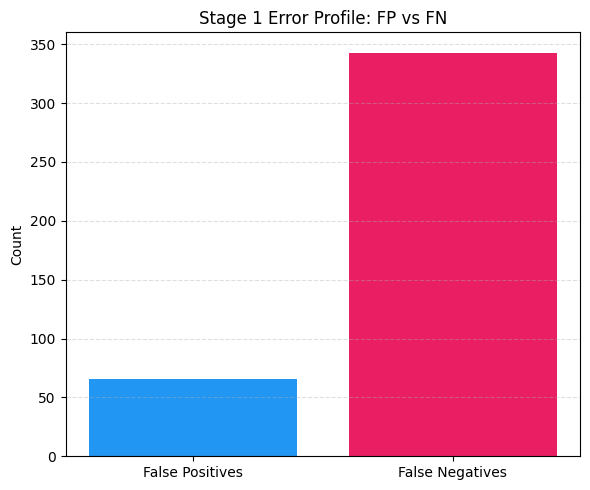

In [47]:
# visualizing FP and FN 

plt.figure(figsize=(6, 5))
plt.bar(["False Positives", "False Negatives"], [FP, FN], color=["#2196F3", "#E91E63"])
plt.ylabel("Count")
plt.title("Stage 1 Error Profile: FP vs FN")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

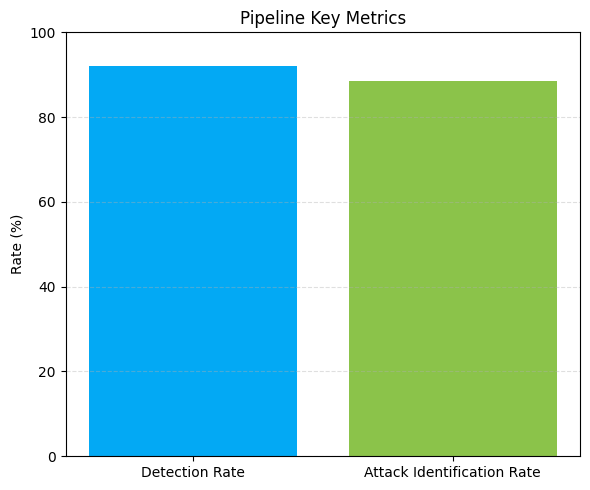

In [48]:
detection_rate_pct = detection_rate * 100
attack_identification_rate_pct = attack_identification_rate * 100

plt.figure(figsize=(6, 5))
plt.bar(["Detection Rate", "Attack Identification Rate"],
        [detection_rate_pct, attack_identification_rate_pct],
        color=["#03A9F4", "#8BC34A"])

plt.ylabel("Rate (%)")
plt.title("Pipeline Key Metrics")
plt.ylim(0, 100)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [49]:
dfA_demo = pd.read_csv("Dataset A.csv")
dfB_demo = pd.read_csv("Dataset B .csv")

session_ids_demo = dfA_demo["session_id"]
print("Loaded demo datasets.")

Loaded demo datasets.


In [50]:
dfA_demo2 = dfA_demo.copy()
dfA_demo2["encryption_used"] = dfA_demo2["encryption_used"].fillna("Unknown")
dfA_demo2 = dfA_demo2.drop(columns=["session_id"])
dfA_demo2 = pd.get_dummies(dfA_demo2, drop_first=True)
dfA_demo2 = dfA_demo2.reindex(columns=dfA_stage1.columns, fill_value=0)

dfA_demo2[num_cols] = scaler.transform(dfA_demo2[num_cols])
X_demo_Stage1 = dfA_demo2.drop(columns=["attack_detected"])

In [51]:
y_pred_demo = xgb_stage1.predict(X_demo_Stage1)

print("\nSample Stage 1 predictions:")
pd.DataFrame({
    "session_id": session_ids_demo.head(10),
    "Stage1_pred": y_pred_demo[:10]
})


Sample Stage 1 predictions:


,session_id,Stage1_pred
0,SID_00001,1
1,SID_00002,0
2,SID_00003,1
3,SID_00004,1
4,SID_00005,0
5,SID_00006,0
6,SID_00007,1
7,SID_00008,1
8,SID_00009,0
9,SID_00010,0


In [38]:
demo_attack_ids = session_ids_demo[y_pred_demo == 1]
print("Predicted malicious:", len(demo_attack_ids))

Predicted malicious: 3987


In [39]:
for col in text_cols:
    dfB_demo[col] = dfB_demo[col].fillna("")

dfB_demo["text"] = dfB_demo[text_cols].agg(" ".join, axis=1)

df_demo_attacks = dfB_demo[dfB_demo["session_id"].isin(demo_attack_ids)]

In [40]:
X_tfidf_demo = tfidf_stage2.transform(df_demo_attacks["text"])
y_demo_Stage2 = svm_stage2.predict(X_tfidf_demo)

demo_output = df_demo_attacks.assign(Predicted_Category=y_demo_Stage2)

print("\nDemo pipeline output (first few rows):")
print(demo_output[["session_id", "Category", "Predicted_Category"]].head())


Demo pipeline output (first few rows):
  session_id                  Category        Predicted_Category
0  SID_00001           Mobile Security  AI Agents & LLM Exploits
1  SID_00003  AI Agents & LLM Exploits  AI Agents & LLM Exploits
2  SID_00004  AI Agents & LLM Exploits  AI Agents & LLM Exploits
3  SID_00007  AI Agents & LLM Exploits  AI Agents & LLM Exploits
4  SID_00008  AI Agents & LLM Exploits  AI Agents & LLM Exploits


In [42]:
final_demo = pd.DataFrame({
    "session_id": df_demo_attacks["session_id"],
    "binary_label": "attack",
    "attack_category": y_demo_Stage2
})

final_demo.head()

,session_id,binary_label,attack_category
0,SID_00001,attack,AI Agents & LLM Exploits
1,SID_00003,attack,AI Agents & LLM Exploits
2,SID_00004,attack,AI Agents & LLM Exploits
3,SID_00007,attack,AI Agents & LLM Exploits
4,SID_00008,attack,AI Agents & LLM Exploits


In [45]:
df_demo_attacks["Category"].value_counts()

Category
Cloud Security                     466
Web Application Security           464
Operating System Exploits          461
Network Security                   460
AI Data Leakage & Privacy Risks    457
Mobile Security                    456
AI/ML Security                     450
AI Agents & LLM Exploits           431
Blockchain / Web3                  273
Network security                     2
 Mobile Security                     1
Name: count, dtype: int64